<a href="https://colab.research.google.com/github/mAn-He/mAn-He/blob/main/%EC%A7%91%EA%B0%921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('/content/drive/MyDrive/데이콘/housing/train.csv')
test = pd.read_csv('/content/drive/MyDrive/데이콘/housing/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/데이콘/housing/sample_submission.csv')

In [3]:
train

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1346,6,1756,Gd,2,422,TA,872,888,Ex,2,1996,1997,1996,204000
1346,1347,9,2748,Gd,3,850,Ex,1850,1850,Ex,2,2006,2006,2006,390000
1347,1348,5,1214,TA,1,318,TA,1214,1214,TA,2,1967,1967,1967,143000
1348,1349,5,894,TA,2,440,TA,864,894,Gd,1,1974,1974,1974,131000


In [4]:
train['Exter Qual'].unique(),train['Bsmt Qual'].unique(),train['Year Built'].unique()

(array(['Ex', 'Gd', 'TA', 'Fa'], dtype=object),
 array(['Ex', 'TA', 'Gd', 'Fa', 'Po'], dtype=object),
 array([2003, 2006, 1967, 1900, 2005, 2009, 1957, 1981, 2001, 1920, 1990,
        1985, 1935, 2002, 1960, 2004, 1993, 1954, 1979, 1963, 1955, 1936,
        1924, 1984, 1918, 1976, 1983, 1947, 1992, 1964, 1978, 1950, 1926,
        1923, 1961, 2007, 1982, 1977, 1996, 1941, 1980, 1974, 1994, 1997,
        1910, 1932, 1953, 1971, 1952, 1972, 1959, 1987, 1951, 1956, 1939,
        1995, 1958, 1962, 1968, 1965, 1999, 1925, 1915, 1940, 1949, 1998,
        1890, 1921, 1934, 1970, 1927, 2008, 1966, 1930, 2000, 1986, 1893,
        1989, 1975, 1945, 1937, 1946, 1885, 1882, 1914, 1928, 1916, 1948,
        1991, 1969, 1938, 1913, 1929, 1942, 1931, 1908, 1922, 1973, 1988,
        1919, 1892, 2010, 1880, 1917, 1912]))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1350 non-null   int64 
 1   Overall Qual    1350 non-null   int64 
 2   Gr Liv Area     1350 non-null   int64 
 3   Exter Qual      1350 non-null   object
 4   Garage Cars     1350 non-null   int64 
 5   Garage Area     1350 non-null   int64 
 6   Kitchen Qual    1350 non-null   object
 7   Total Bsmt SF   1350 non-null   int64 
 8   1st Flr SF      1350 non-null   int64 
 9   Bsmt Qual       1350 non-null   object
 10  Full Bath       1350 non-null   int64 
 11  Year Built      1350 non-null   int64 
 12  Year Remod/Add  1350 non-null   int64 
 13  Garage Yr Blt   1350 non-null   int64 
 14  target          1350 non-null   int64 
dtypes: int64(12), object(3)
memory usage: 158.3+ KB


In [6]:
train.columns[(train.dtypes == object)]


Index(['Exter Qual', 'Kitchen Qual', 'Bsmt Qual'], dtype='object')

In [7]:
train['Garage Cars'].unique()

array([3, 2, 1, 4, 5])

In [8]:
Exter_dumm = pd.get_dummies(train['Exter Qual'])
Exter_dumm.rename(columns = {'Ex':'Exter_Ex', 'Fa':'Exter_Fa','Gd': 'Exter_Gd', 'TA':'Exter_TA'}, inplace = True)

In [9]:
Kitchen_dumm = pd.get_dummies(train['Kitchen Qual'])
Kitchen_dumm.rename(columns={'Ex':'Kitchen_Ex', 'Fa':'Kitchen_Fa','Gd': 'Kitchen_Gd', 'TA':'Kitchen_TA'}, inplace = True)
Bsmt_dumm = pd.get_dummies(train['Bsmt Qual'])
Bsmt_dumm.rename(columns={'Ex':'Bsmt_Ex', 'Fa':'Bsmt_Fa','Gd': 'Bsmt_Gd', 'Po':'Bsmt_Po','TA':'Bsmt_TA'}, inplace = True)

In [10]:
train = pd.concat((train, Exter_dumm), axis=1)
train = pd.concat((train, Kitchen_dumm), axis=1)
train = pd.concat((train, Bsmt_dumm), axis=1)


In [11]:
train

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target,Exter_Ex,Exter_Fa,Exter_Gd,Exter_TA,Kitchen_Ex,Kitchen_Fa,Kitchen_Gd,Kitchen_TA,Bsmt_Ex,Bsmt_Fa,Bsmt_Gd,Bsmt_Po,Bsmt_TA
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250,1,0,0,0,1,0,0,0,1,0,0,0,0
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000,0,0,1,0,0,0,1,0,1,0,0,0,0
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000,0,0,0,1,0,0,0,1,0,0,0,0,1
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000,0,0,0,1,0,0,1,0,0,0,0,0,1
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000,0,0,1,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1346,6,1756,Gd,2,422,TA,872,888,Ex,2,1996,1997,1996,204000,0,0,1,0,0,0,0,1,1,0,0,0,0
1346,1347,9,2748,Gd,3,850,Ex,1850,1850,Ex,2,2006,2006,2006,390000,0,0,1,0,1,0,0,0,1,0,0,0,0
1347,1348,5,1214,TA,1,318,TA,1214,1214,TA,2,1967,1967,1967,143000,0,0,0,1,0,0,0,1,0,0,0,0,1
1348,1349,5,894,TA,2,440,TA,864,894,Gd,1,1974,1974,1974,131000,0,0,0,1,0,0,0,1,0,0,1,0,0


In [12]:
train.isna().sum()

id                0
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
Exter_Ex          0
Exter_Fa          0
Exter_Gd          0
Exter_TA          0
Kitchen_Ex        0
Kitchen_Fa        0
Kitchen_Gd        0
Kitchen_TA        0
Bsmt_Ex           0
Bsmt_Fa           0
Bsmt_Gd           0
Bsmt_Po           0
Bsmt_TA           0
dtype: int64

In [13]:
Exter_dumm = pd.get_dummies(test['Exter Qual'])
Exter_dumm.rename(columns = {'Ex':'Exter_Ex', 'Fa':'Exter_Fa','Gd': 'Exter_Gd', 'TA':'Exter_TA'}, inplace = True)
Kitchen_dumm = pd.get_dummies(test['Kitchen Qual'])
Kitchen_dumm.rename(columns={'Ex':'Kitchen_Ex', 'Fa':'Kitchen_Fa','Gd': 'Kitchen_Gd', 'TA':'Kitchen_TA'}, inplace = True)
Bsmt_dumm = pd.get_dummies(test['Bsmt Qual'])
Bsmt_dumm.rename(columns={'Ex':'Bsmt_Ex', 'Fa':'Bsmt_Fa','Gd': 'Bsmt_Gd', 'Po':'Bsmt_Po','TA':'Bsmt_TA'}, inplace = True)

In [14]:
test = pd.concat((test, Exter_dumm), axis=1)
test = pd.concat((test, Kitchen_dumm), axis=1)
test = pd.concat((test, Bsmt_dumm), axis=1)


In [15]:
test

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,Exter_Ex,Exter_Fa,Exter_Gd,Exter_TA,Kitchen_Ex,Kitchen_Fa,Kitchen_Gd,Po,Kitchen_TA,Bsmt_Ex,Bsmt_Fa,Bsmt_Gd,Bsmt_Po,Bsmt_TA
0,1,9,1800,Gd,2,702,Ex,1800,1800,Ex,2,2007,2007,2007,0,0,1,0,1,0,0,0,0,1,0,0,0,0
1,2,6,1082,TA,1,240,TA,1082,1082,TA,1,1948,1950,1948,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,3,6,1573,Gd,2,440,Gd,756,769,Gd,2,2000,2000,2000,0,0,1,0,0,0,1,0,0,0,0,1,0,0
3,4,6,2443,Gd,3,744,Gd,1158,1158,Gd,2,2004,2004,2004,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,5,5,1040,TA,2,686,TA,1040,1040,TA,1,1968,1968,1991,0,0,0,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1346,8,1932,Ex,3,774,Ex,1932,1932,Ex,2,2008,2008,2008,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1346,1347,5,912,TA,1,288,TA,912,912,TA,1,1964,1964,1964,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1347,1348,4,861,TA,2,288,TA,861,861,Fa,1,1920,1950,1920,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1348,1349,5,1430,TA,2,624,Gd,1430,1430,Ex,2,2004,2005,2004,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [16]:
train.drop(['id'], axis =1, inplace=True)

In [17]:
train.describe()

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target,Exter_Ex,Exter_Fa,Exter_Gd,Exter_TA,Kitchen_Ex,Kitchen_Fa,Kitchen_Gd,Kitchen_TA,Bsmt_Ex,Bsmt_Fa,Bsmt_Gd,Bsmt_Po,Bsmt_TA
count,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,6.208889,1513.542222,1.870370,502.014815,1082.644444,1167.474074,1.560741,1972.987407,1985.099259,1978.471852,186406.312593,0.036296,0.005926,0.359259,0.598519,0.079259,0.017037,0.414815,0.488889,0.099259,0.020741,0.431111,0.000741,0.448148
std,1.338015,487.523239,0.652483,191.389956,384.067713,375.061407,0.551646,29.307257,20.153244,25.377278,78435.424758,0.187096,0.076780,0.479961,0.490380,0.270243,0.129457,0.492873,0.500062,0.299121,0.142568,0.495415,0.027217,0.497488
min,2.000000,480.000000,1.000000,100.000000,105.000000,480.000000,0.000000,1880.000000,1950.000000,1900.000000,12789.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1144.000000,1.000000,368.000000,816.000000,886.250000,1.000000,1955.000000,1968.000000,1961.000000,135000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1445.500000,2.000000,484.000000,1009.000000,1092.500000,2.000000,1976.000000,1993.000000,1978.500000,165375.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,1774.500000,2.000000,588.000000,1309.500000,1396.500000,2.000000,2002.000000,2004.000000,2002.000000,217875.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,10.000000,4476.000000,5.000000,1488.000000,2660.000000,2898.000000,4.000000,2010.000000,2010.000000,2207.000000,745000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
num_features = [
                'Overall Qual',
                'Gr Liv Area',
                'Garage Cars',
                'Total Bsmt SF',
                'Year Built'
                ,'Year Remod/Add',
                'Garage Yr Blt'
                ]

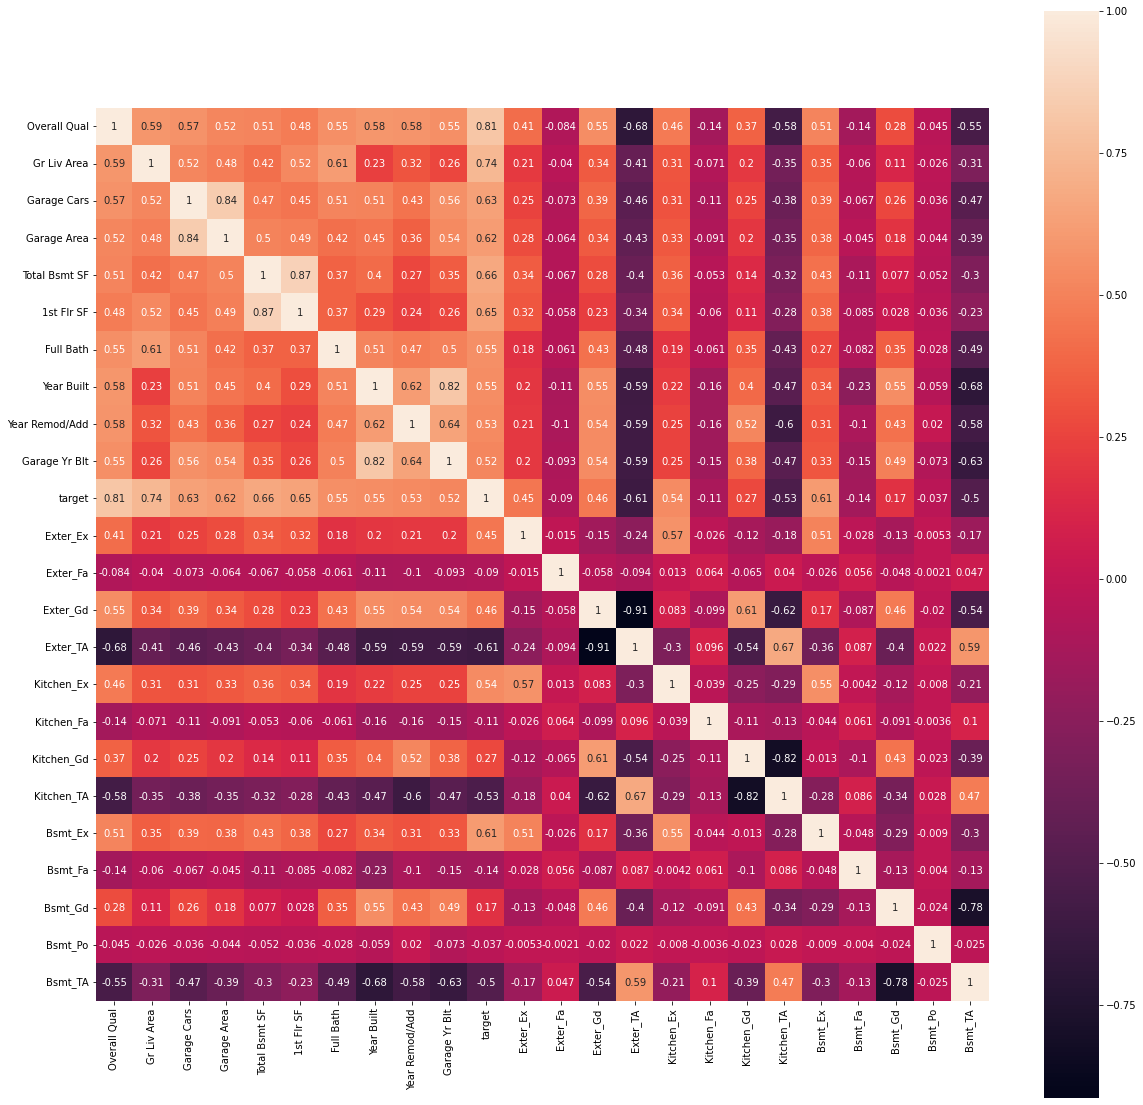

In [19]:


plt.subplots(figsize=(20,20))

sns.heatmap(train.corr(), mask=np.zeros_like(train.corr(), dtype=bool),
            square=True, annot=True)
plt.show()

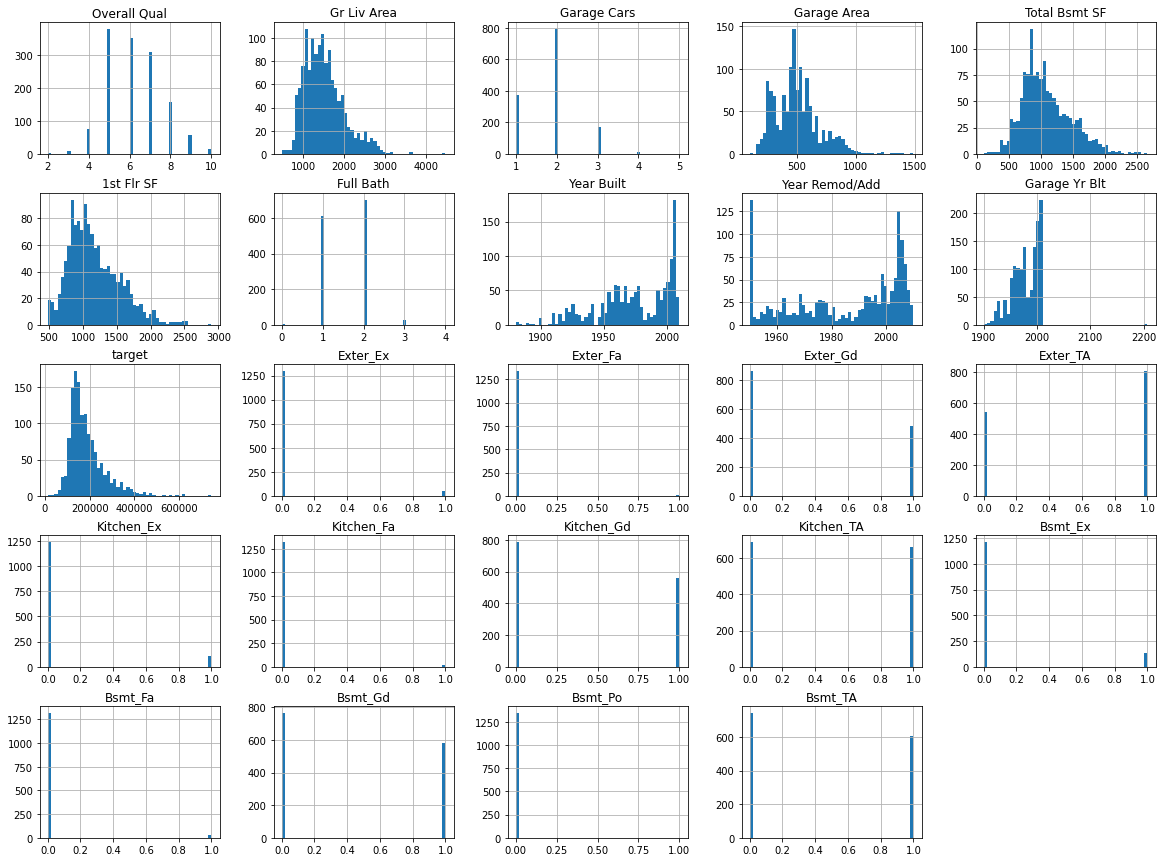

In [20]:
train.hist(bins=50, figsize=(20,15))
plt.show()

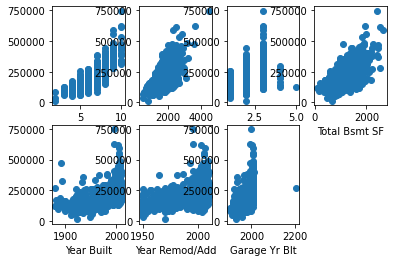

In [21]:
for i in range(len(num_features)):
  plt.subplot(2,4,i+1)
  plt.xlabel(num_features[i])
  plt.scatter(train[num_features[i]], train['target'])

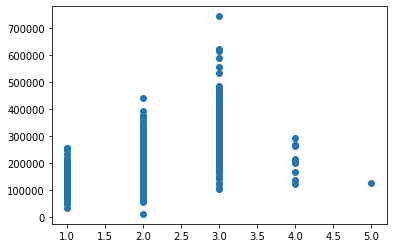

In [22]:
plt.scatter(train[num_features[2]], train['target'])

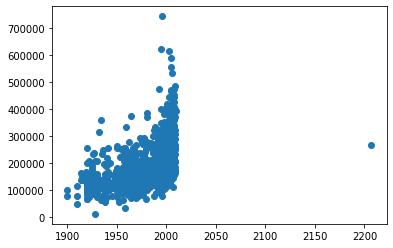

In [23]:
  plt.scatter(train['Garage Yr Blt'], train['target'])

In [24]:
features = [
            'Overall Qual',
            'Gr Liv Area',
            'Garage Cars',	'Garage Area',
            'Total Bsmt SF',	'1st Flr SF',
            'Full Bath',	'Year Built',	'Year Remod/Add',
            'Garage Yr Blt',
            'Exter_Ex',
            'Exter_Fa',
            'Exter_Gd',
            'Exter_TA'
            ,'Kitchen_Ex',
            'Kitchen_Fa',
            'Kitchen_Gd',
            'Kitchen_TA',
            'Bsmt_Ex',
            'Bsmt_Fa',
            'Bsmt_Gd',
            'Bsmt_Po',
            'Bsmt_TA',


]

In [25]:
X = train[features]
y = train['target']

In [26]:
X.head(0)

,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,Exter_Ex,Exter_Fa,Exter_Gd,Exter_TA,Kitchen_Ex,Kitchen_Fa,Kitchen_Gd,Kitchen_TA,Bsmt_Ex,Bsmt_Fa,Bsmt_Gd,Bsmt_Po,Bsmt_TA


In [27]:
y = pd.DataFrame(y)
y.head()

,target
0,386250
1,194000
2,123000
3,135000
4,250000


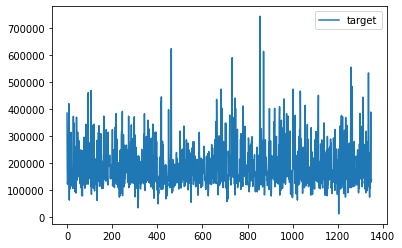

In [28]:
y.plot()

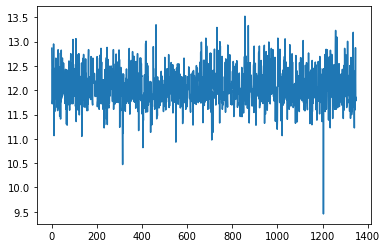

In [29]:
Y_log = np.log1p(y['target'])
Y_log.plot()

In [30]:
from sklearn.model_selection import train_test_split

# train 및 test 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
# y값이 log 형인 데이터 분할
x_train, x_test, y_train_log, y_test_log = train_test_split(X ,Y_log, random_state=0, test_size=0.2)

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [32]:
def nmae(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [35]:
from sklearn.metrics import mean_squared_error
def rmse(test_pred, y_test):
    return np.sqrt(mean_squared_error(test_pred, y_test))

In [38]:
models=[RandomForestRegressor(random_state=0), KNeighborsRegressor(), BaggingRegressor(random_state=0),
        GradientBoostingRegressor(random_state=23), 
        XGBRegressor(random_state=43), LGBMRegressor(random_state=0),
        AdaBoostRegressor(random_state=0), LinearRegression(), SVR(kernel='poly', degree = 2), SVR(kernel='rbf'), 
        Lasso(random_state=0), Ridge(random_state=0),
        ]
     
model_names=['RandomForestRegressor', 'KNeighborsRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor',
             'AdaBoostRegressor', 'LinearRegression', 'SVR_poly', 'SVR_rbf', 'Lasso', 'Ridge'
          ]
nmae_list=[]
# d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)

    k=0
    for i in test_pred:
      if i<0:
        test_pred[k] = 0
      k+=1

    test_pred=test_pred.reshape(270,1)
    nmae_list.append(nmae(test_pred,y_test))


for model in range(len(model_names)):
  print(model_names[model], 'NMAE : \t\t' , nmae_list[model] , '\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[02:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForestRegressor NMAE : 		 target    0.10056
dtype: float64 

KNeighborsRegressor NMAE : 		 target    0.135858
dtype: float64 

BaggingRegressor NMAE : 		 target    0.10667
dtype: float64 

GradientBoostingRegressor NMAE : 		 target    0.097599
dtype: float64 

XGBRegressor NMAE : 		 target    0.09656
dtype: float64 

LGBMRegressor NMAE : 		 target    0.100284
dtype: float64 

AdaBoostRegressor NMAE : 		 target    0.116783
dtype: float64 

LinearRegression NMAE : 		 target    0.11087
dtype: float64 

SVR_poly NMAE : 		 target    0.304438
dtype: float64 

SVR_rbf NMAE : 		 target    0.304652
dtype: float64 

Lasso NMAE : 		 target    0.110869
dtype: float64 

Ridge NMAE : 		 target    0.110915
dtype: float64 



In [39]:
from sklearn.model_selection import GridSearchCV


parameters = {
    "n_estimators" : [30,40,50,60,70,80, 85, 90, 95, 100],
    'n_jobs' : [-1],
    'learning_rate': [0.1, 0.05],
    }
    
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(LGBMRegressor(random_state=0), parameters, verbose=2, cv=5)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ......learning_rate=0.1, n_estimators=30, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=30, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=30, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=30, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=30, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=40, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=40, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=40, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=40, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=40, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=50, n_jobs=-1; total time=   0.1s
[CV] END ......learning_rate=0.1, n_estimators=

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': [0.1, 0.05],
                         'n_estimators': [30, 40, 50, 60, 70, 80, 85, 90, 95,
                                          100],
                         'n_jobs': [-1]},
             verbose=2)

In [40]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 50, 'n_jobs': -1}

In [41]:
parameters = {
    "n_estimators" : [50, 55,60,65,70,75,80,90],
    'max_depth' : [2,3],
    'n_jobs' : [-1],
    'learing_rate' : [0.1, 0.2, 0.01, 0.05]
    }
    
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(XGBRegressor(random_state=0), parameters, verbose=2, cv=5)
grid.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[02:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1; total time=   0.1s
[02:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1; total time=   0.1s
[02:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1; total time=   0.1s
[02:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1; total time=   0.1s
[02:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is 

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'learing_rate': [0.1, 0.2, 0.01, 0.05],
                         'max_depth': [2, 3],
                         'n_estimators': [50, 55, 60, 65, 70, 75, 80, 90],
                         'n_jobs': [-1]},
             verbose=2)

In [42]:
grid.best_params_

{'learing_rate': 0.1, 'max_depth': 3, 'n_estimators': 90, 'n_jobs': -1}

In [43]:
parameters = {
    "n_estimators" : [50, 55,60,65,70,75,80,90],
    'max_depth' : [2,3,4,5,6,7,8,9,20]
    
    
    }
    
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(RandomForestRegressor(random_state=0), parameters, verbose=2, cv=5)
grid.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=55; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=55; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=55; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=55; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=55; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=60; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=60; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=60; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=60; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=60; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=65; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=65; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=65; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=70; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=70; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=75; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=75; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=75; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=80; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=80; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=90; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=90; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=90; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=90; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=2, n_estimators=90; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=60; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=60; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=65; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=65; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=65; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=70; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=70; total time=   0.2s

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] END .......................max_depth=3, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=80; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=80; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=90; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=3, n_estimators=90; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=60; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=60; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=70; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=75; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=4, n_estimators=90; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=55; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=65; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=90; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=90; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=5, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=55; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=60; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=80; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=6, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=75; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=7, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=50; total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=70; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=90; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=8, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=55; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=60; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=65; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=70; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=75; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=80; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .......................max_depth=9, n_estimators=90; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=50; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=50; total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=55; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=55; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=55; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=55; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=55; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=60; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=60; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=60; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=60; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=60; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=65; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=65; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=65; total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=70; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=70; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=70; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=70; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=70; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=75; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=75; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=75; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=75; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=75; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=80; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=80; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=80; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=80; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=80; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=90; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=90; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=90; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=90; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ......................max_depth=20, n_estimators=90; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 20],
                         'n_estimators': [50, 55, 60, 65, 70, 75, 80, 90]},
             verbose=2)

In [44]:
grid.best_params_

{'max_depth': 20, 'n_estimators': 80}

In [45]:
model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, reg_lambda = 5, random_state=0, learning_rate=0.1).fit(X, Y_log)
model_xgb = XGBRegressor(n_estimators = 90, n_jobs=-1, random_state=0, max_depth=3, learning_rate=0.1).fit(X, Y_log)
model_ri= RandomForestRegressor(max_depth = 20, n_estimators=80).fit(X, Y_log)


[02:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [46]:
LSTM_pred = model_lstm.predict(test[features])
XGB_pred =  model_xgb.predict(test[features])
RL_pred = model_ri.predict(test[features])

In [47]:
LSTM_pred = (np.expm1(LSTM_pred.reshape(-1,1)))
XGB_pred = (np.expm1(XGB_pred.reshape(-1,1)))
RL_pred = (np.expm1(RL_pred.reshape(-1,1)))

In [48]:
XGB_pred

array([[332584.75],
       [131109.58],
       [170645.75],
       ...,
       [ 73998.45],
       [190279.34],
       [141523.56]], dtype=float32)

In [49]:
LSTM_pred

array([[343617.33795712],
       [122602.49162639],
       [176178.78252833],
       ...,
       [ 71797.24057087],
       [197707.8748701 ],
       [138779.12845458]])

In [50]:
RL_pred

array([[330587.49557114],
       [125676.17958281],
       [178304.74537364],
       ...,
       [ 78216.15309672],
       [215835.34026753],
       [150179.54647068]])

In [51]:
Hosuing = RL_pred * 0.35 + LSTM_pred * 0.3 +  XGB_pred * 0.35
Hosuing

array([[335195.48889954],
       [126655.7619044 ],
       [174986.30735802],
       ...,
       [ 74814.28473949],
       [201452.49717967],
       [143729.82589486]])

In [52]:
submission['target'] =  Hosuing
submission

,id,target
0,1,335195.488900
1,2,126655.761904
2,3,174986.307358
3,4,231704.638953
4,5,131061.611194
...,...,...
1345,1346,322522.992212
1346,1347,126583.906043
1347,1348,74814.284739
1348,1349,201452.497180


In [53]:
submission.to_csv('Hosuing1.csv', index=False)